<a href="https://colab.research.google.com/github/mohit-bags/Arrhythmia-Detection/blob/main/ResNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Keras modules and its important APIs
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten

from tensorflow.keras.optimizers import Adam 
from keras.utils import np_utils
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os



In [ ]:
# Setting Training Hyperparameters
batch_size = 32 # original ResNet paper uses batch_size = 128 for training
epochs = 200
data_augmentation = True
num_classes = 10

# Data Preprocessing
subtract_pixel_mean = True
n = 3

# Select ResNet Version
version = 1

# Computed depth of
if version == 1:
	depth = n * 6 + 2
elif version == 2:
	depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet % dv % d' % (depth, version)

# Load the CIFAR-10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
	x_train_mean = np.mean(x_train, axis = 0)
	x_train -= x_train_mean
	x_test -= x_train_mean

# Print Training and Test Samples
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [ ]:
# Setting LR for different number of Epochs
def lr_schedule(epoch):
	lr = 1e-3
	if epoch > 180:
		lr *= 0.5e-3
	elif epoch > 160:
		lr *= 1e-3
	elif epoch > 120:
		lr *= 1e-2
	elif epoch > 80:
		lr *= 1e-1
	print('Learning rate: ', lr)
	return lr


https://keras.io/api/layers/convolution_layers/convolution1d/

Conv1d

In [ ]:
# tf.keras.layers.Conv1D(
#     filters,
#     kernel_size,
#     strides=1,
#     padding="valid",
#     data_format="channels_last",
#     dilation_rate=1,
#     groups=1,
#     activation=None,
#     use_bias=True,
#     kernel_initializer="glorot_uniform",
#     bias_initializer="zeros",
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     **kwargs
# )

In [ ]:
# Basic ResNet Building Block
def resnet_layer(inputs,
				num_filters = 16,
				kernel_size = 3,
				strides = 1,
				activation ='relu',
				batch_normalization = True,
        conv_first=False):

  conv = Conv2D(num_filters,
          kernel_size = kernel_size,
          strides = strides,
          padding ='same',
          kernel_initializer ='he_normal',
          kernel_regularizer = l2(1e-4))
  x = inputs
  if conv_first:
    x = conv(x)
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
  else:
    if batch_normalization:
      x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
    x = conv(x)
  return x


In [ ]:
#
def resnet_v1(input_shape, depth, num_classes = 10):
	
	if (depth - 2) % 6 != 0:
		raise ValueError('depth should be 6n + 2 (eg 20, 32, 44 in [a])')
	# Start model definition.
	num_filters = 16
	num_res_blocks = int((depth - 2) / 6)

	inputs = Input(shape = input_shape)
	x = resnet_layer(inputs = inputs)
	# Instantiate the stack of residual units
	for stack in range(3):
		for res_block in range(num_res_blocks):
			strides = 1
			if stack > 0 and res_block == 0: # first layer but not first stack
				strides = 2 # downsample
			y = resnet_layer(inputs = x,
							num_filters = num_filters,
							strides = strides)
			y = resnet_layer(inputs = y,
							num_filters = num_filters,
							activation = None)
			if stack > 0 and res_block == 0: # first layer but not first stack
				# linear projection residual shortcut connection to match
				# changed dims
				x = resnet_layer(inputs = x,
								num_filters = num_filters,
								kernel_size = 1,
								strides = strides,
								activation = None,
								batch_normalization = False)
			x = keras.layers.add([x, y])
			x = Activation('relu')(x)
		num_filters *= 2

	# Add classifier on top.
	# v1 does not use BN after last shortcut connection-ReLU
	x = AveragePooling2D(pool_size = 8)(x)
	y = Flatten()(x)
	outputs = Dense(num_classes,
					activation ='softmax',
					kernel_initializer ='he_normal')(y)

	# Instantiate model.
	model = Model(inputs = inputs, outputs = outputs)
	return model


In [ ]:
# ResNet V2 architecture
def resnet_v2(input_shape, depth, num_classes = 10):
	if (depth - 2) % 9 != 0:
		raise ValueError('depth should be 9n + 2 (eg 56 or 110 in [b])')
	# Start model definition.
	num_filters_in = 16
	num_res_blocks = int((depth - 2) / 9)

	inputs = Input(shape = input_shape)
	# v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
	x = resnet_layer(inputs = inputs,
					num_filters = num_filters_in,
					conv_first = True)

	# Instantiate the stack of residual units
	for stage in range(3):
		for res_block in range(num_res_blocks):
			activation = 'relu'
			batch_normalization = True
			strides = 1
			if stage == 0:
				num_filters_out = num_filters_in * 4
				if res_block == 0: # first layer and first stage
					activation = None
					batch_normalization = False
			else:
				num_filters_out = num_filters_in * 2
				if res_block == 0: # first layer but not first stage
					strides = 2 # downsample

			# bottleneck residual unit
			y = resnet_layer(inputs = x,
							num_filters = num_filters_in,
							kernel_size = 1,
							strides = strides,
							activation = activation,
							batch_normalization = batch_normalization,
							conv_first = False)
			y = resnet_layer(inputs = y,
							num_filters = num_filters_in,
							conv_first = False)
			y = resnet_layer(inputs = y,
							num_filters = num_filters_out,
							kernel_size = 1,
							conv_first = False)
			if res_block == 0:
				# linear projection residual shortcut connection to match
				# changed dims
				x = resnet_layer(inputs = x,
								num_filters = num_filters_out,
								kernel_size = 1,
								strides = strides,
								activation = None,
								batch_normalization = False)
			x = keras.layers.add([x, y])

		num_filters_in = num_filters_out

	# Add classifier on top.
	# v2 has BN-ReLU before Pooling
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = AveragePooling2D(pool_size = 8)(x)
	y = Flatten()(x)
	outputs = Dense(num_classes,
					activation ='softmax',
					kernel_initializer ='he_normal')(y)

	# Instantiate model.
	model = Model(inputs = inputs, outputs = outputs)
	return model


In [ ]:
# Main function
if version == 2:
	model = resnet_v2(input_shape = input_shape, depth = depth)
else:
	model = resnet_v1(input_shape = input_shape, depth = depth)

model.compile(loss ='categorical_crossentropy',
			optimizer = Adam(learning_rate = lr_schedule(0)),
			metrics =['accuracy'])
model.summary()
print(model_type)

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_% s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
	os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath = filepath,
							monitor ='val_acc',
							verbose = 1,
							save_best_only = True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
							cooldown = 0,
							patience = 5,
							min_lr = 0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
	print('Not using data augmentation.')
	model.fit(x_train, y_train,
			batch_size = batch_size,
			epochs = epochs,
			validation_data =(x_test, y_test),
			shuffle = True,
			callbacks = callbacks)
else:
	print('Using real-time data augmentation.')
	# This will do preprocessing and realtime data augmentation:
	datagen = ImageDataGenerator(
		# set input mean to 0 over the dataset
		featurewise_center = False,
		# set each sample mean to 0
		samplewise_center = False,
		# divide inputs by std of dataset
		featurewise_std_normalization = False,
		# divide each input by its std
		samplewise_std_normalization = False,
		# apply ZCA whitening
		zca_whitening = False,
		# epsilon for ZCA whitening
		zca_epsilon = 1e-06,
		# randomly rotate images in the range (deg 0 to 180)
		rotation_range = 0,
		# randomly shift images horizontally
		width_shift_range = 0.1,
		# randomly shift images vertically
		height_shift_range = 0.1,
		# set range for random shear
		shear_range = 0.,
		# set range for random zoom
		zoom_range = 0.,
		# set range for random channel shifts
		channel_shift_range = 0.,
		# set mode for filling points outside the input boundaries
		fill_mode ='nearest',
		# value used for fill_mode = "constant"
		cval = 0.,
		# randomly flip images
		horizontal_flip = True,
		# randomly flip images
		vertical_flip = False,
		# set rescaling factor (applied before any other transformation)
		rescale = None,
		# set function that will be applied on each input
		preprocessing_function = None,
		# image data format, either "channels_first" or "channels_last"
		data_format = None,
		# fraction of images reserved for validation (strictly between 0 and 1)
		validation_split = 0.0)

	# Compute quantities required for featurewise normalization
	# (std, mean, and principal components if ZCA whitening is applied).
	datagen.fit(x_train)

	# Fit the model on the batches generated by datagen.flow().
	model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
						validation_data =(x_test, y_test),
						epochs = epochs, verbose = 1, workers = 4,
						callbacks = callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_2[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 3)    0           ['batch_normalization[0][0]']    
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['activ

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1563/1563 [==============================] - 75s 39ms/step - loss: 1.7350 - accuracy: 0.4271 - val_loss: 1.6108 - val_accuracy: 0.4894 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
1563/1563 [==============================] - 62s 40ms/step - loss: 1.3214 - accuracy: 0.5893 - val_loss: 1.2779 - val_accuracy: 0.6191 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
1563/1563 [==============================] - 61s 39ms/step - loss: 1.1168 - accuracy: 0.6663 - val_loss: 1.1036 - val_accuracy: 0.6673 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
1563/1563 [==============================] - 64s 41ms/step - loss: 1.0092 - accuracy: 0.7099 - val_loss: 1.0225 - val_accuracy: 0.7140 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
1563/1563 [==============================] - 61s 39ms/step - loss: 0.9363 - accuracy: 0.7370 - val_loss: 1.0711 - val_accuracy: 0.7019 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
1563/1563 [==============================] - 62s 39ms/step - loss: 0.8966 - accuracy: 0.75

In [ ]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

### ResNet Identity & Convolution block
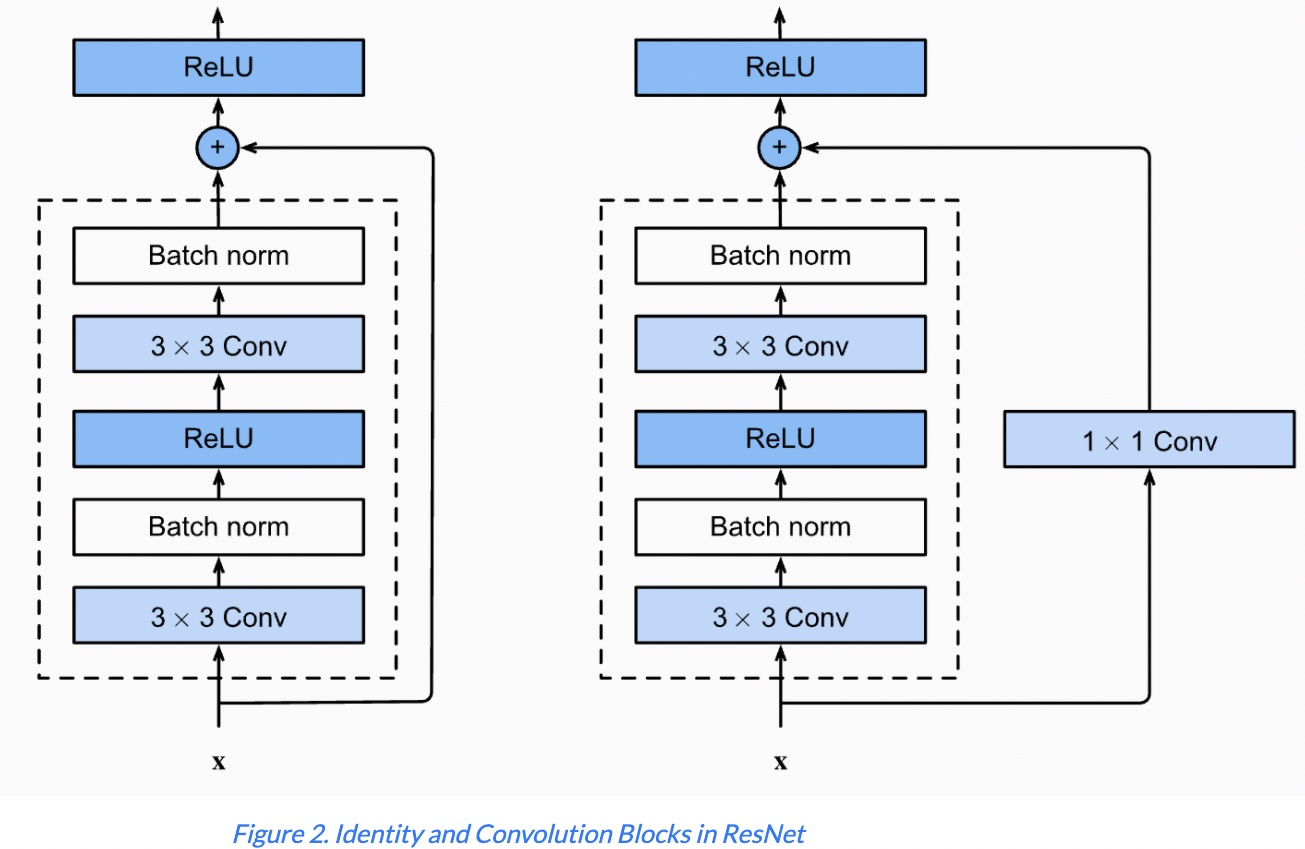

##### Use this formula to check input and residue(o/p) size for same size
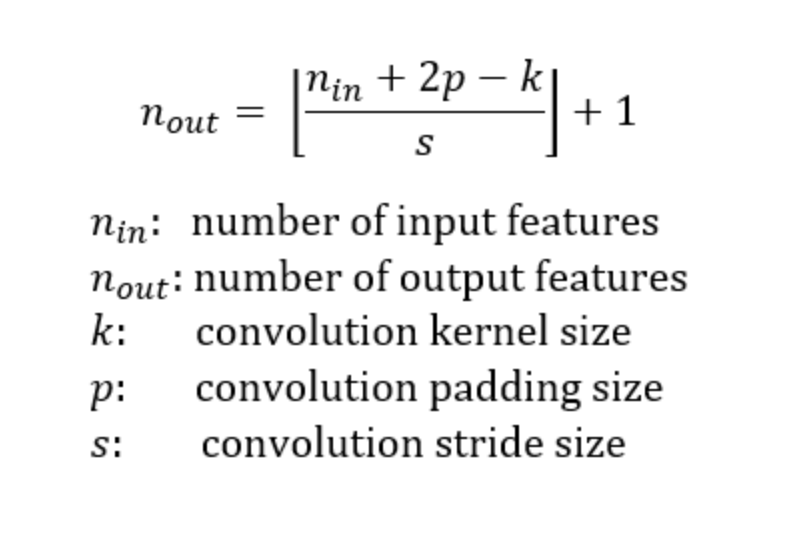

In [ ]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, concatenate, Input
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K


# Multitowered 1D-CNN for concatenated feature set
def concat_1d_CNN(n_class, n_col):    
    
    input_shape = Input(shape=(n_col,1))

    tower_1 = Conv1D(nb_filter = 5, kernel_size = 15, strides = 1, activation = 'relu')(input_shape)
    tower_1 = Dropout(0.25)(tower_1)
    tower_1 = (MaxPooling1D(pool_size=2))(tower_1)

    tower_2 = Conv1D(nb_filter = 5, kernel_size = 15, strides = 1, activation = 'relu')(input_shape)
    tower_2 = Dropout(0.25)(tower_2)
    tower_2 = (MaxPooling1D(pool_size=2))(tower_2)

    merged = concatenate([tower_1, tower_2], axis=1)
    merged = Flatten()(merged)

    out = Dense(200, activation='relu')(merged)
    out = Dropout(0.25)(out)
    out = Dense(50, activation='relu')(out)
    out = Dropout(0.1)(out)
    if n_class > 2:
        out = Dense(n_class, activation='softmax')(out)
    else:
        out = Dense(n_class, activation='sigmoid')(out)
    model = Model(input_shape, out)
    return model

# Mulitowered 1D-CNN for seperated feature set
def sep_1d_CNN(n_class, input_shape_dict):
    
    input_stft = Input(shape=(input_shape_dict['len_stft'],1))
    input_mfccs = Input(shape=(input_shape_dict['len_mfccs'],1))
    input_chroma = Input(shape=(input_shape_dict['len_chroma'],1))
    input_mel = Input(shape=(input_shape_dict['len_mel'],1))
    input_contrast = Input(shape=(input_shape_dict['len_contrast'],1))
    input_tonnetz = Input(shape=(input_shape_dict['len_tonnetz'],1))
    
    tower_stft = Conv1D(nb_filter = 5, kernel_size = 5, strides = 1, activation = 'relu', use_bias = False)(input_stft)
    tower_stft = Dropout(0.25)(tower_stft)
    tower_stft = (MaxPooling1D(pool_size=2))(tower_stft)
    
    tower_mfccs = Conv1D(nb_filter = 5, kernel_size = 5, strides = 1, activation = 'relu', use_bias = False)(input_mfccs)
    tower_mfccs = Dropout(0.25)(tower_mfccs)
    tower_mfccs = (MaxPooling1D(pool_size=2))(tower_mfccs)
    
    tower_chroma = Conv1D(nb_filter = 5, kernel_size = 5, strides = 1, activation = 'relu', use_bias = False)(input_chroma)
    tower_chroma = Dropout(0.25)(tower_chroma)
    tower_chroma = (MaxPooling1D(pool_size=2))(tower_chroma)
    
    tower_mel = Conv1D(nb_filter = 5, kernel_size = 5, strides = 1, activation = 'relu', use_bias = False)(input_mel)
    tower_mel = Dropout(0.25)(tower_mel)
    tower_mel = (MaxPooling1D(pool_size=2))(tower_mel)
    
    tower_contrast = Conv1D(nb_filter = 5, kernel_size = 5, strides = 1, activation = 'relu', use_bias = False)(input_contrast)
    tower_contrast = Dropout(0.25)(tower_contrast)
    tower_contrast = (MaxPooling1D(pool_size=2))(tower_contrast)
    
    tower_tonnetz = Conv1D(nb_filter = 5, kernel_size = 5, strides = 1, activation = 'relu', use_bias = False)(input_tonnetz)
    tower_tonnetz = Dropout(0.25)(tower_tonnetz)
    tower_tonnetz = (MaxPooling1D(pool_size=2))(tower_tonnetz)
    
    merged = concatenate([tower_stft, tower_mfccs, tower_chroma, tower_mel, tower_contrast, tower_tonnetz], axis=1)
    merged = Flatten()(merged)
    
    out = Dense(200, activation='relu', use_bias = False)(merged)
    out = Dropout(0.25)(out)
    out = Dense(50, activation='relu', use_bias = False)(out)
    out = Dropout(0.1)(out)
    if n_class > 2:
        out = Dense(n_class, activation='softmax')(out)
    else:
        out = Dense(n_class, activation='sigmoid')(out)
    
    model = Model([input_stft,input_mfccs,input_chroma,input_mel,input_contrast,input_tonnetz], out)
    return model

In [ ]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
import warnings

from os import listdir
from os.path import isdir, join

# function to load data
def data_loader(dir_path):
    warnings.filterwarnings('ignore')
    alldirs = [d for d in listdir(dir_path)if isdir(join(dir_path, d))]
    out_X = []
    out_Y = []
    for i in alldirs:
        allfiles = [f for f in listdir(join(dir_path, i))if not f.endswith(('.csv','.json','.DS_Store'))]
        for fp in tqdm(allfiles):
            try: 
                X,sr = librosa.load(join(dir_path, i, fp), sr = 11025)
                out_X.append(X)
                out_Y.append(str(i))
            except:
                next
    return out_X, out_Y

# function to reshape all lists to common length by adding trailing 0s
def padder(X):
    max_len = max([len(i) for i in X])
    for j in tqdm(X):
        j = librosa.util.fix_length(j,max_len)   
    return X,max_len

# function to extract features
def feat_extract_concat(X):
    out = []
    for i in tqdm(X):
        i = np.array(i)
        stft = np.mean(np.abs(librosa.stft(i)).T, axis = 0)
        mfccs = np.mean(librosa.feature.mfcc(i, sr = 11025).T, axis = 0)
        chroma = np.mean(librosa.feature.chroma_stft(i, sr = 11025).T, axis = 0)
        mel = np.mean(librosa.feature.melspectrogram(i, sr = 11025).T, axis = 0)
        contrast = np.mean(librosa.feature.spectral_contrast(i, sr = 11025, n_bands = 4).T, axis = 0)
        tonnetz = np.mean(librosa.feature.tonnetz(librosa.effects.harmonic(i), sr = 11025).T, axis = 0)
        out_tmp = list(stft)+list(mfccs)+list(chroma)+list(mel)+list(contrast)+list(tonnetz)
        out.append(out_tmp)
    return out

def feat_extract_sep(X):
    out_stft = []
    out_mfccs = []
    out_chroma = []
    out_mel = []
    out_contrast = []
    out_tonnetz = []
    out_cqt = []
    out_cens = []
    out_rmse = []
    out_spcentroid = []
    out_spband = []
    out_sproll = []
    out_poly = []
    out_zcr = []
    for i in tqdm(X):
        i = np.array(i)
        out_stft.append(list(np.mean(np.abs(librosa.stft(i)).T, axis = 0)))
        out_mfccs.append(list(np.mean(librosa.feature.mfcc(i, sr = 11025).T, axis = 0)))
        out_chroma.append(list(np.mean(librosa.feature.chroma_stft(i, sr = 11025).T, axis = 0)))
        out_mel.append(list(np.mean(librosa.feature.melspectrogram(i, sr = 11025).T, axis = 0)))
        out_contrast.append(list(np.mean(librosa.feature.spectral_contrast(i, sr = 11025, n_bands = 4).T, axis = 0)))
        out_tonnetz.append(list(np.mean(librosa.feature.tonnetz(librosa.effects.harmonic(i), sr = 11025).T, axis = 0)))
    return out_stft,out_mfccs,out_chroma,out_mel,out_contrast,out_tonnetz